In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [3]:
path = Config().data_path()/'rossmann'
train_df = pd.read_pickle(path/'train_clean')

In [4]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [5]:
n = len(train_df); n

844338

### Experimenting with a sample

Just using a few of the available columns.

On a particular date, for a particular store ID, we want to be able to predict the sales.

In [6]:
# this is data preprocessing

# grab 2000 ids at random
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [7]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
752,754,5,"Mar,Jun,Sept,Dec",380.0,62,8920
1146,34,4,NaN,2240.0,55,8443
1502,391,4,"Feb,May,Aug,Nov",460.0,73,6777
1515,404,4,"Mar,Jun,Sept,Dec",1420.0,60,6772
1942,831,4,NaN,800.0,73,13681


In [8]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
421313,517,2,NaN,22490.0,53,7347
421398,602,2,"Mar,Jun,Sept,Dec",2710.0,53,8880
422575,666,1,"Mar,Jun,Sept,Dec",2700.0,58,9905
423464,410,6,"Mar,Jun,Sept,Dec",40.0,48,4452
424826,664,5,NaN,1680.0,84,4569


In [9]:
# fast.ai helper function to do astype('category')
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [10]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
421313,NaN,2,NaN,22490.0,53,7347
421398,602.0,2,"Mar,Jun,Sept,Dec",2710.0,53,8880
422575,666.0,1,"Mar,Jun,Sept,Dec",2700.0,58,9905
423464,NaN,6,"Mar,Jun,Sept,Dec",40.0,48,4452
424826,NaN,5,NaN,1680.0,84,4569


In [11]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [12]:
small_train_df['PromoInterval'].cat.codes[:5]

752     2
1146   -1
1502    0
1515    2
1942   -1
dtype: int8

In [15]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [16]:
# missing information might be important here so keep it in boolean state
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
8113,291,4,NaN,2400.0,69,6263,True
89602,622,6,NaN,2400.0,78,2845,True
106055,291,3,NaN,2400.0,82,6413,True
255081,622,4,NaN,2400.0,90,3427,True


### Preparing full data set

In [17]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [18]:
len(train_df),len(test_df)

(844338, 41088)

In [19]:
# pass in preprocessors as list
procs=[FillMissing, Categorify, Normalize]

In [20]:
# need lists of categorical and continuous variables to create a databunch

# day, month, year are categorical here as we don't necessarily expect continuous behaviour in Sales
# if number of categories is low for something numerical, then generally better to put as a categorical variable
# (but try both)
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [21]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [22]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [23]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [24]:
valid_idx = range(cut)

In [25]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [26]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   # split into train and test
                   .split_by_idx(valid_idx)
                   # label using independent variable. label_cls tells it that the independent variable is a float, 
                   # so we've got a regression rather than classification problem.
                   # Taking log of y as we can use RMSE as a loss function which is a difference from RMSPE on Kaggle
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .databunch())

In [27]:
doc(FloatList)

## Model

In [28]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [29]:
# tabular_learner is a simple, fully connected network
# we have a 500,000 element weight matrix for fewer rows so the network will overfit
# Therefore we're using dropout in ps, and emb_drop
# ps = p value for dropout for each layer
# emb_drop = special amount of dropout for the embedding layer (the one-hot encoded vector times the input matrix)
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [30]:
learn.model
# embeddings; embedding dropout; 
# batchnorm1d with 16 inputs for 16 columns - batch norm doesn't reduce covariate shift, but allows an increase
# in learning rate by reducing how bumpy the training loss curve is

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [32]:
len(data.train_ds.cont_names)

16

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


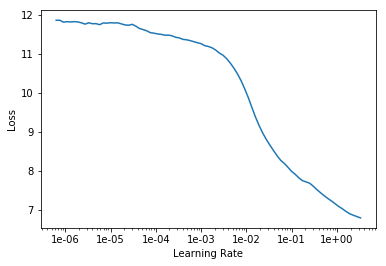

In [34]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.023486,0.019252,0.134078,02:58
1,0.017884,0.020945,0.139152,02:59
2,0.015942,0.022470,0.133131,02:56
3,0.013729,0.012476,0.113908,02:36
4,0.011500,0.010523,0.102743,02:37


In [36]:
learn.save('1')

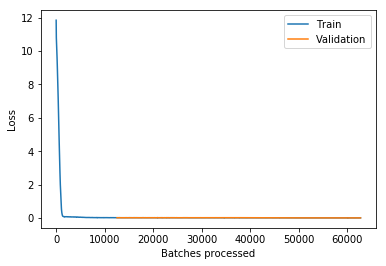

In [39]:
learn.recorder.plot_losses()#last=-1)

In [40]:
learn.load('1');

In [41]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.011287,0.011449,0.108772,02:35
1,0.012212,0.013752,0.114810,02:35
2,0.012179,0.018534,0.114112,03:01
3,0.010677,0.013054,0.108599,06:37
4,0.008669,0.013746,0.109329,02:28


In [42]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.010813,0.013282,0.110394,02:27
1,0.011225,0.021067,0.126117,02:27
2,0.010443,0.020909,0.133566,02:30
3,0.008944,0.022593,0.129944,02:29
4,0.009544,0.021054,0.126937,02:28


(10th place in the competition was 0.108)

## fin